In [135]:
#Set up environment and import necessary dependencies

%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division;
from __future__ import print_function;
from __future__ import absolute_import;
import sys, os;
from collections import OrderedDict, namedtuple;
import numpy as np;

#Import some general util stuff
scriptsDir = os.environ.get("UTIL_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable UTIL_SCRIPTS_DIR to point to av_scripts");
sys.path.insert(0,scriptsDir);
import pathSetter;
import util;
import fileProcessing as fp
from plottingUtilitiesPackage import matplotlibHelpers as mplh;

#import deepLIFT stuff
scriptsDir = os.environ.get("ENHANCER_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable ENHANCER_SCRIPTS_DIR to point to enhancer_prediction_code");
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/");
import criticalSubsetIdentification as csi
import deepLIFTutils
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/kerasBasedBackprop");
from deepLIFTonGPU import ScoreTypes, Activations_enum, OutLayerInfo, getScoreFunc

#Make sure the directory is set to import the lab's version of keras
scriptsDir = os.environ.get("KERAS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable KERAS_DIR");
sys.path.insert(0,scriptsDir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
#load the data
import pickle
import criticalSubsetIdentification as csi
pickle_name="/srv/scratch/annashch/heterokaryon/DeepLIFTanalysis/heterokaryon.grammars.1.pkl"
data=open(pickle_name,'rb')
grammars=pickle.load(data)
grammarsCorrMat=pickle.load(data)
data.close() 

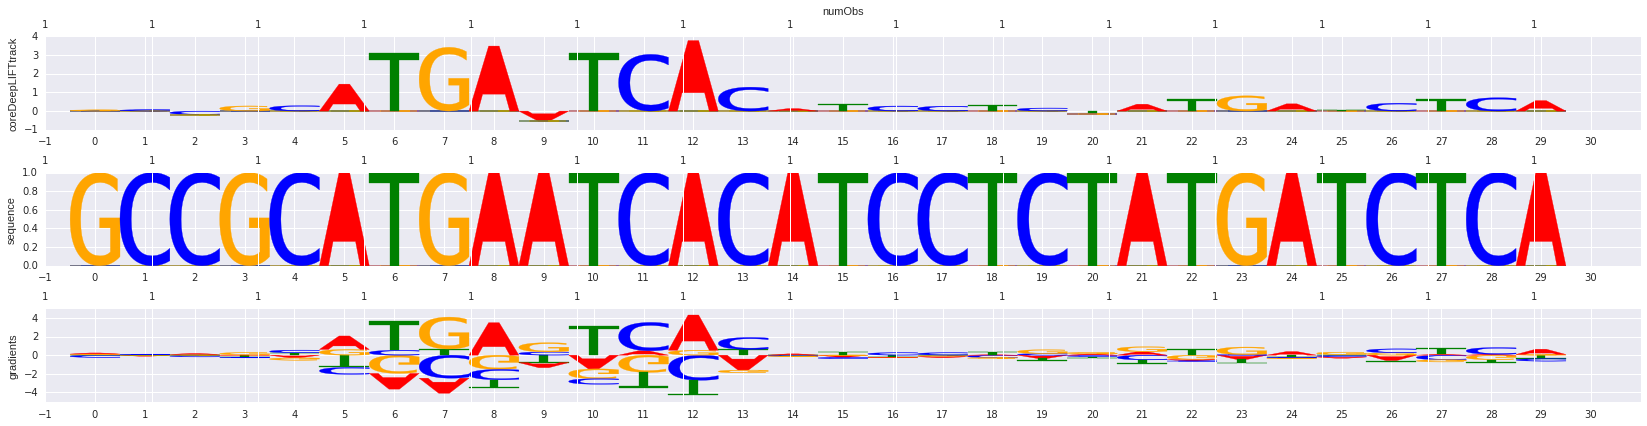

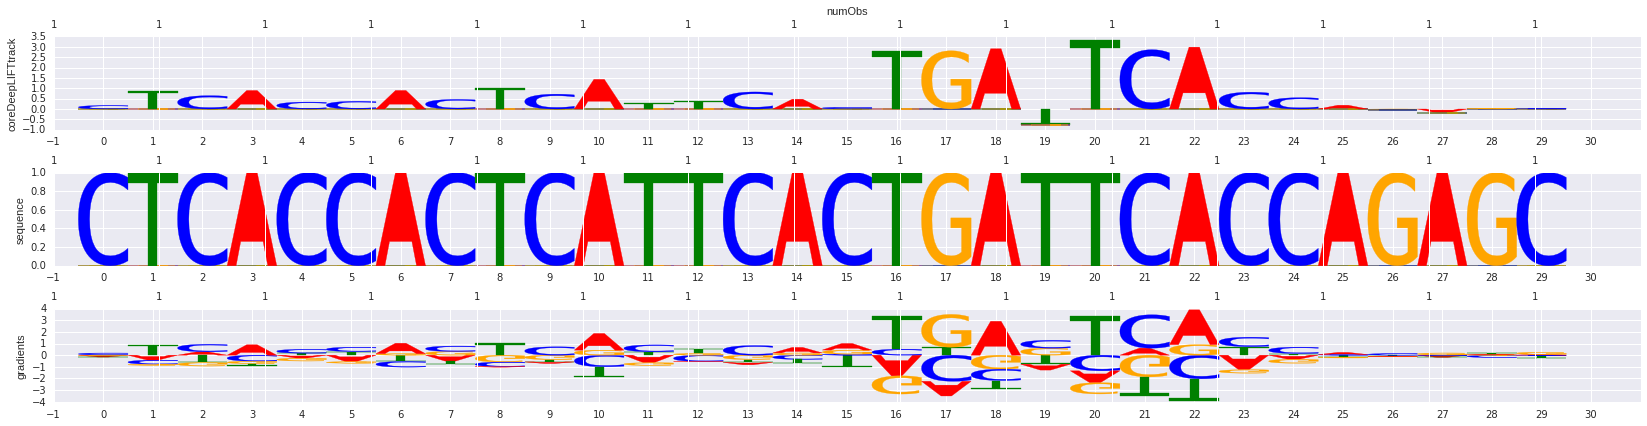

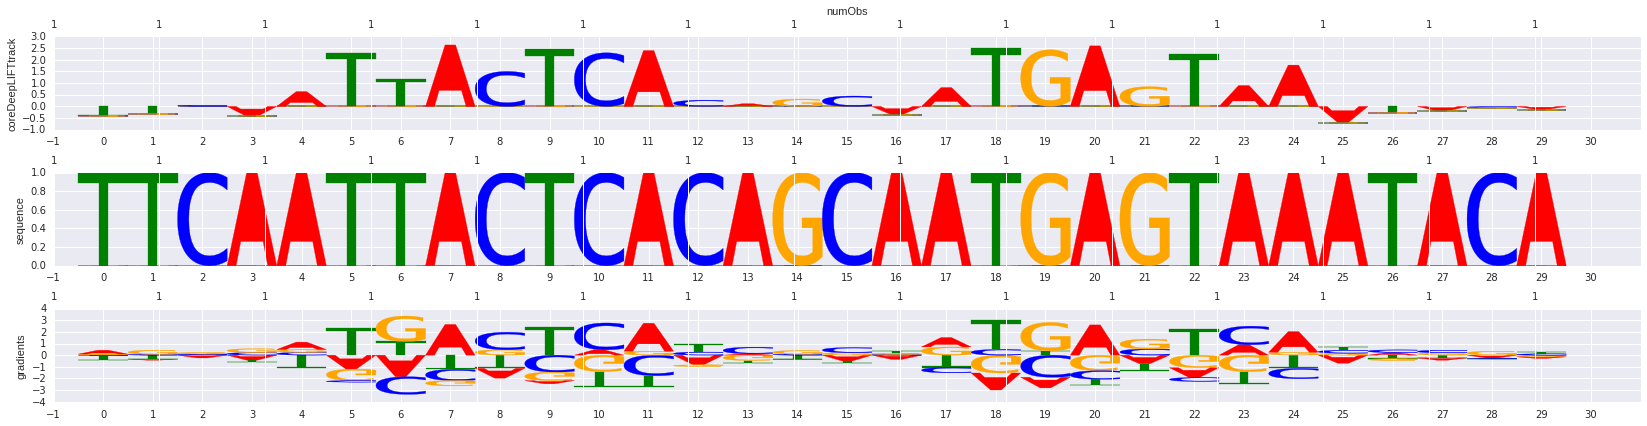

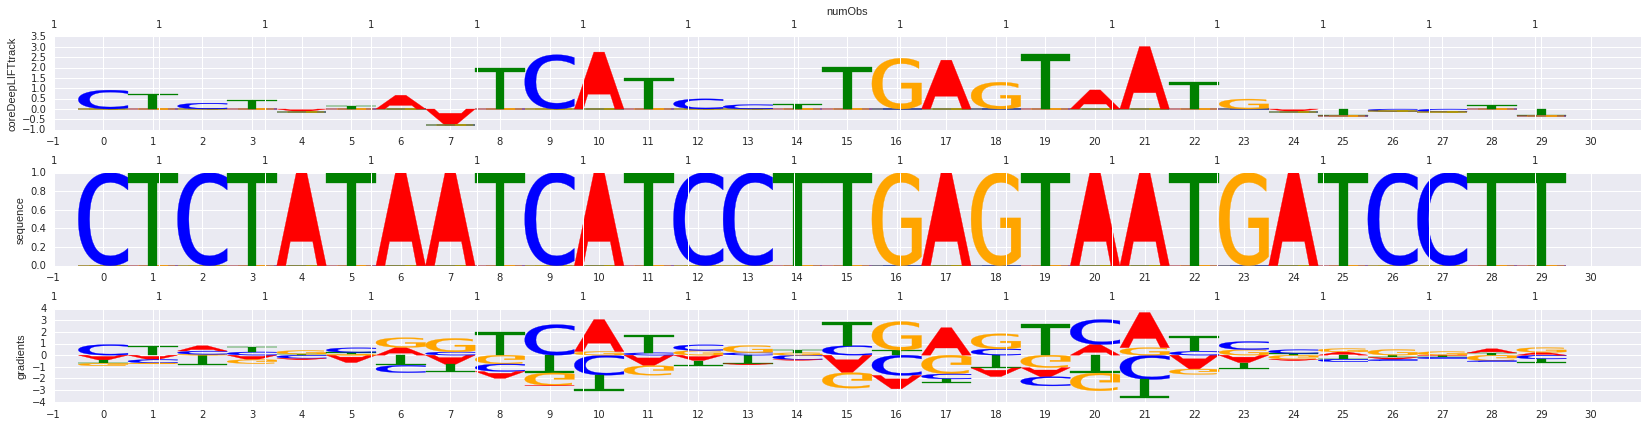

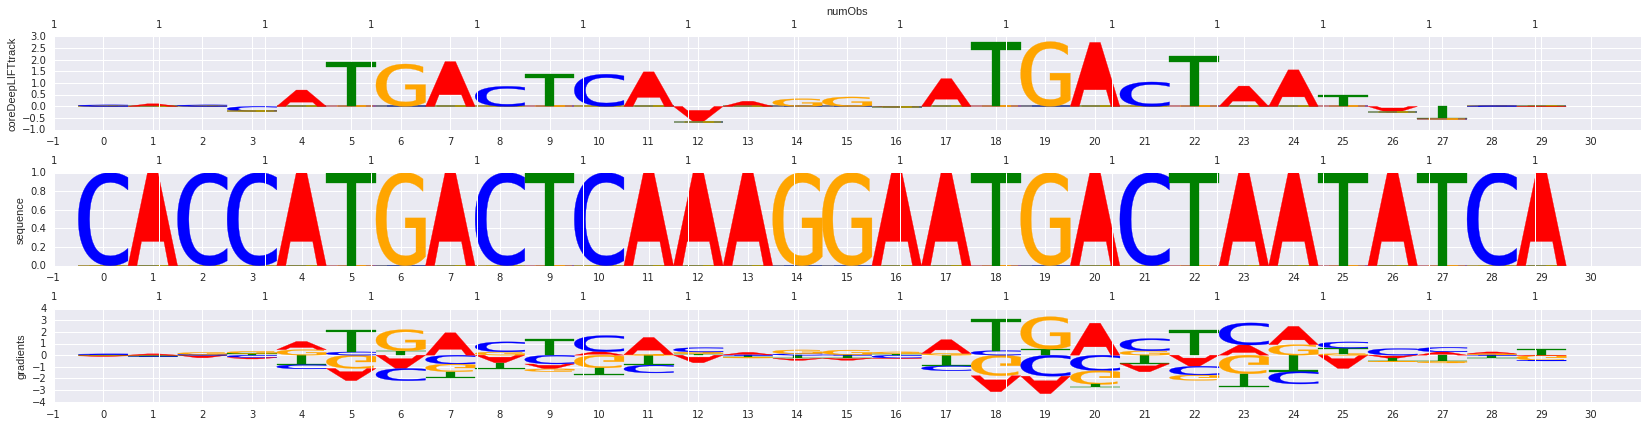

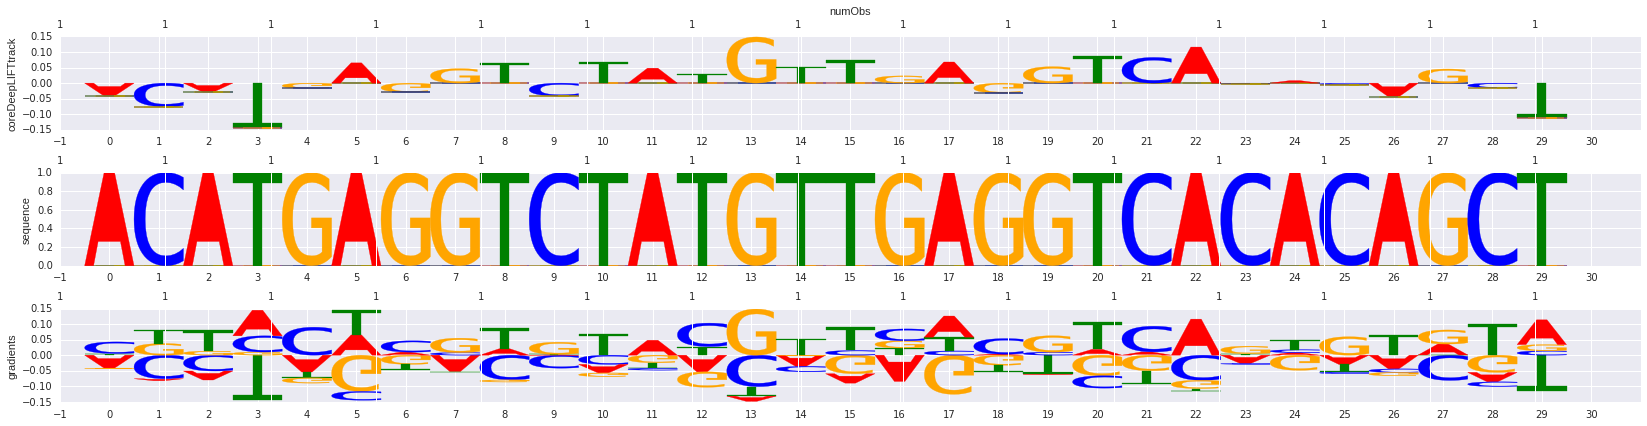

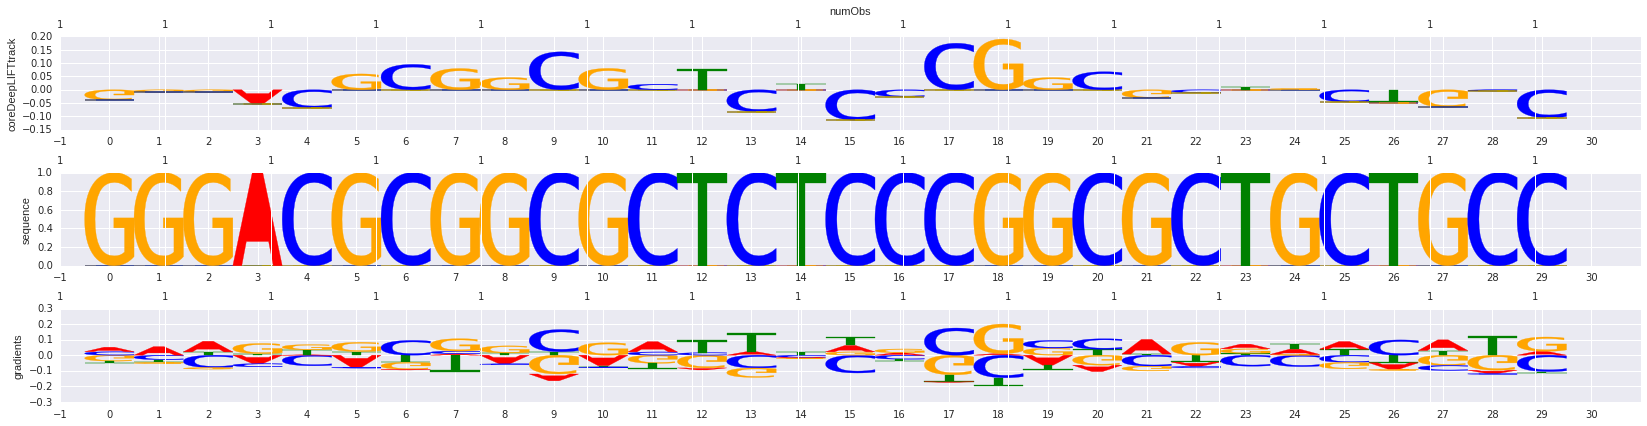

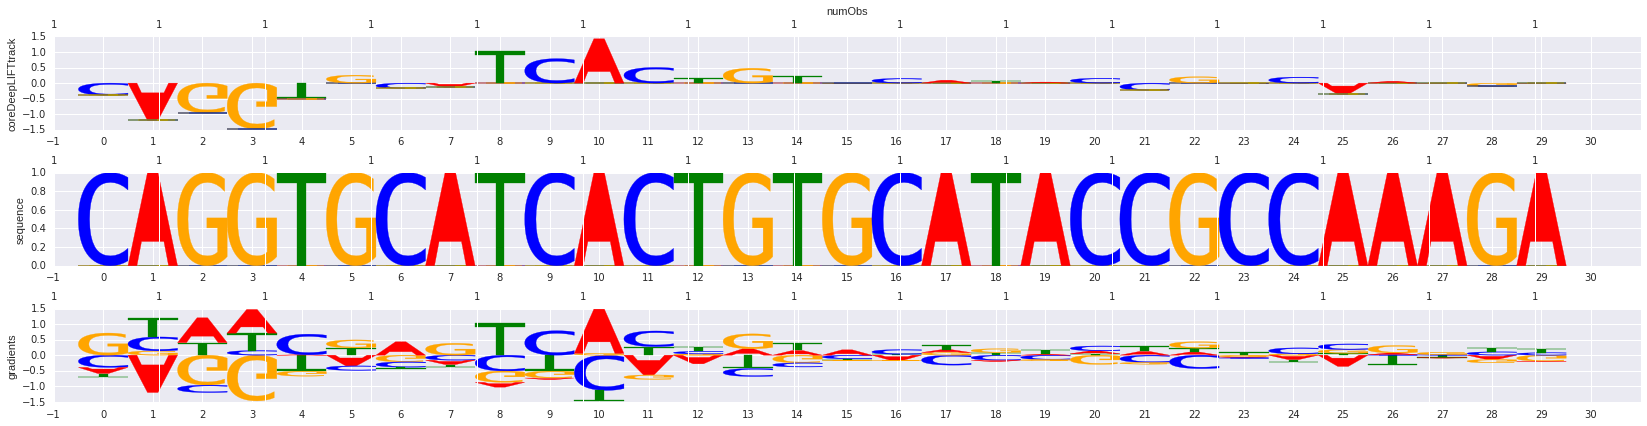

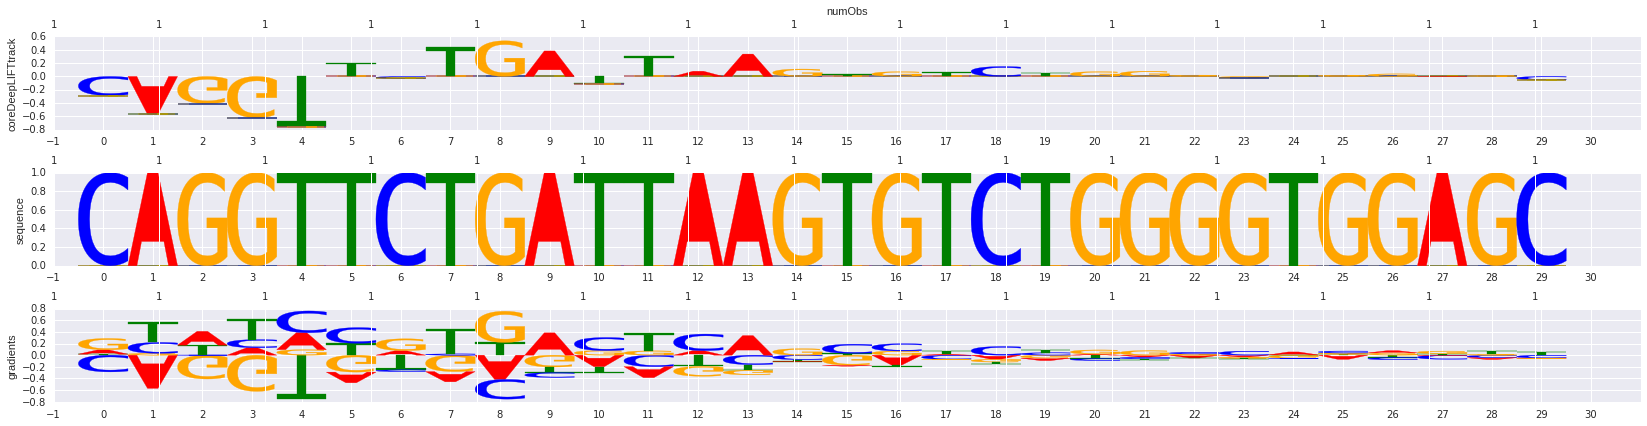

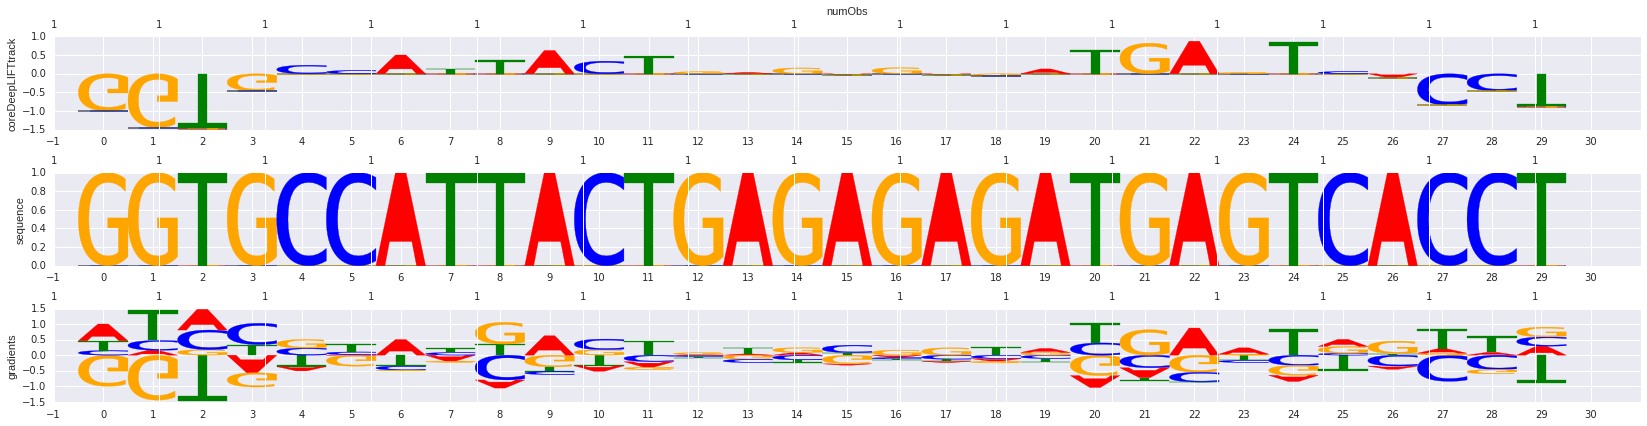

In [137]:
#visually explore the grammars originating from a few examples to get a sense of what they look like
reload(csi)
trackNamesToPrint=[csi.coreDeepLIFTtrackName, "sequence", "gradients"]
for idx in range(5):
    csi.printGrammarWithIdx(grammars, idx=idx, trackNamesToPrint=trackNamesToPrint, heightPerTrack=2);
for idx in range(-5,0):
    csi.printGrammarWithIdx(grammars, idx=idx, trackNamesToPrint=trackNamesToPrint, heightPerTrack=2);
    

In [138]:
#coarse initializations for k-medoids clustering 
from kmedoids import kmedoids 
KMEANS_NUM_CLUSTERS=20 #number of initial coarse clusters using k-means 
KMEANS_INITS=10 #number of initializations for k-means 



In [139]:
subtracksToInclude=["gradients"]
os.environ['CUDA_DEVICE']="7" #you should set this if you plan to do xcor on the GPU                                                                                                             
grammarsCorrMat = csi.getCorrelationMatrix(
                        grammars
                        , normaliseFunc=util.CROSSC_NORMFUNC.meanAndTwoNorm
                        , subtracksToInclude=subtracksToInclude
                        , accountForRevComp=True
                        , numThreads=1
                        , secondsBetweenUpdates=3
                        , xcorBatchSize=10 #set this to something other than None to do xcor on GPU                                                                                                          
                        #, subtrackNormaliseFunc=util.CROSSC_NORMFUNC.perPositionRange                                                                                                                       
                        )


Num words: 2061
FFT size 128
FFT time: 0.0218079090118
EWPMK time: 0.966778278351
ifft time: 2.45394062996
MAI time: 59.471091032
FFT size 128
FFT time: 0.0205869674683
EWPMK time: 0.992246389389
ifft time: 2.50728034973
MAI time: 59.4961166382
Seconds to compute corr mat: 127.909427166


In [140]:
#k-medoids clustering 
import numpy as np 
max_grammars_cc=np.max(grammarsCorrMat,axis=1)
len(max_grammars_cc)
max_cc=grammarsCorrMat.max() 
min_cc=grammarsCorrMat.min() 
print("max_cc:"+str(max_cc))
print("min_cc:"+str(min_cc))


corr_mat_diag=grammarsCorrMat.diagonal() 
assert 0 <=min_cc and max_cc <=1
grammarsCorrMat*=-1 
grammarsCorrMat+=1 
np.fill_diagonal(grammarsCorrMat,0)


max_cc:0.999999880791
min_cc:0.0263672303408


In [141]:
labels, _, _ = kmedoids(grammarsCorrMat, n_clusters=KMEANS_NUM_CLUSTERS,
                            n_init=KMEANS_INITS)


Initial cost: 501.552764803
Iter 0 - Cost: 430.246104896, Min cost: 430.246104896
Iter 1 - Cost: 424.195257634, Min cost: 424.195257634
Iter 2 - Cost: 421.183747083, Min cost: 421.183747083
Iter 3 - Cost: 418.631168008, Min cost: 418.631168008
Iter 4 - Cost: 417.675703675, Min cost: 417.675703675
Iter 5 - Cost: 415.781123608, Min cost: 415.781123608
Iter 6 - Cost: 415.781123608, Min cost: 415.781123608
Terminating: no improvement in the last 1 steps
Initial cost: 495.380872279
Iter 0 - Cost: 436.759942889, Min cost: 436.759942889
Iter 1 - Cost: 419.575584412, Min cost: 419.575584412
Iter 2 - Cost: 416.794646472, Min cost: 416.794646472
Iter 3 - Cost: 415.206939042, Min cost: 415.206939042
Iter 4 - Cost: 414.708735883, Min cost: 414.708735883
Iter 5 - Cost: 414.708735883, Min cost: 414.708735883
Terminating: no improvement in the last 1 steps
Initial cost: 491.250350773
Iter 0 - Cost: 429.213090569, Min cost: 429.213090569
Iter 1 - Cost: 424.081836045, Min cost: 424.081836045
Iter 2 - C

In [142]:
#import criticalSubsetIdentification as csi
reload(csi)
merged_grammars, original_shifts = csi.merge_grammars(labels,grammars,subtracksToInclude=subtracksToInclude,
        normaliseFunc=util.CROSSC_NORMFUNC.meanAndTwoNorm,
        accountForRevComp=True)



In [143]:
# trim grammars        
TRIM_FRAC=0.3
trimmingFunc = csi.TrimArrayColumnsToNumUnderlyingObs(TRIM_FRAC)
merged_grammars = csi.adjustGrammarsUsingTrimmingCriterion(
    merged_grammars, trimmingFunc=trimmingFunc)
print("finished!")



finished!


In [145]:
import criticalSubsetIdentification as csi
reload(csi)

from agglomerative_clustering import * 
# perform agglomorative clustering         
agglomerated_grammars, agglomerated_indices = agglomerative_clustering(
    merged_grammars, subtracksToInclude[0], cc_threshold=0.9)


Num words: 20
Seconds to compute corr mat: 0.567417144775
('max cc: ', 0.98560647655199218)
Num words: 19
Seconds to compute corr mat: 0.413688898087
('max cc: ', 0.9613329236922028)


AttributeError: 'tuple' object has no attribute 'totalObservationsEver'

In [ ]:

#import deepLIFTonGPU
#import deepLIFTutils
#import criticalSubsetIdentification as csi 
#import xcor
#reload(deepLIFTutils)
#reload(deepLIFTonGPU)
#reload(csi)
#reload(util)
#reload(xcor)
print(str(merged_grammars.values()[0]))
subtracksToInclude=["gradients"]
os.environ['CUDA_DEVICE']="7"
merged_grammars_cc = csi.getCorrelationMatrix(
    merged_grammars.values(),
    subtracksToInclude=subtracksToInclude,
    accountForRevComp=True,
    numThreads=1,
    secondsBetweenUpdates=3,
    xcorBatchSize=None,
    smallerPerPosNormFuncs=[util.PERPOS_NORMFUNC.oneOverTwoNorm],
    largerPerPosNormFuncs=[util.PERPOS_NORMFUNC.oneOverTwoNorm])


In [ ]:
plot_clustering_heatmap(merged_grammars_cc, agglomerated_indices)


In [ ]:
def convert_pwm_to_bits(pwm, pseudocount=1e-6):
    # WARNING: Modifies PWM in place                                                                                                                                                                         
    assert pwm.shape[0] == 4
    pwm *= 2 + (pwm * np.log2(pwm + pseudocount)).sum(axis=0, keepdims=True)


In [ ]:
for grammar in agglomerated_grammars:
    convert_pwm_to_bits(grammar.getNormalisedDataTrack('sequence'))

In [ ]:
reload(csi)
print(len(agglomerated_grammars))
cur_index=0 
forward_figs=[] 
reverse_figs=[] 
for grammar in agglomerated_grammars:
    print(str(cur_index))
    cur_fig=csi.printGrammar(grammar, trackNamesToPrint=[csi.Grammar.coreDeepLIFTtrackName, "sequence", "gradients"])
    cur_fig_rev=csi.printGrammar(grammar.getRevCompGrammar(), trackNamesToPrint=[csi.Grammar.coreDeepLIFTtrackName, "sequence","gradients"])
    forward_figs.append(csi.fig2img(cur_fig))
    reverse_figs.append(csi.fig2img(cur_fig_rev))
    cur_index+=1
    

In [ ]:
#get top hits to various databases
reload(csi)
#compareToKnownMotifs expects a dict 
agglomerated_dict=dict(zip(range(len(agglomerated_grammars)),agglomerated_grammars))
hits=csi.compareToKnownMotifs_returndata(agglomerated_dict, trackNameForComparison="gradients")

In [ ]:
print(hits)

In [ ]:
print(forward_figs[0])

In [ ]:
hit_dict={1:hits}
forward_fig_dict={1:forward_figs}
reverse_fig_dict={1:reverse_figs}
for i in range(1,25): 
    forward_fig_dict[i]=[] 
    reverse_fig_dict[i]=[]
    

In [ ]:
from generate_html import * 
dirname="/srv/scratch/annashch/heterokaryon/DeepLIFTanalysis/grammar_html"
generate_html(dirname,hit_dict,forward_fig_dict,reverse_fig_dict)